#### Importando bibliotecas

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from collections import Counter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA



import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import datetime as dt
import numpy as np
from datetime import datetime
import statsmodels.api as sm


#### Carregando dados

In [3]:
path = os.path.join('VendasTesouroDireto_1.json')
values = pd.read_json(path)
df_data = pd.DataFrame(values)
df_data['Tipo_Titulo'] = df_data['Tipo_Titulo'].astype('str') 
df_data['PU'] = df_data['PU'].str.replace(',', '.')
df_data['Quantidade'] = df_data['Quantidade'].str.replace(',', '.')
df_data['Valor'] = df_data['Valor'].str.replace(',', '.')
df_data['PU'] = pd.to_numeric(df_data['PU'], errors='coerce')
df_data['Quantidade'] = pd.to_numeric(df_data['Quantidade'], errors='coerce')
df_data['Valor'] = pd.to_numeric(df_data['Valor'], errors='coerce')
df_data['Vencimento_do_Titulo'] = pd.to_datetime(df_data['Vencimento_do_Titulo'])
df_data['Data_Venda'] = pd.to_datetime(df_data['Data_Venda'])


df_data

,Tipo_Titulo,Vencimento_do_Titulo,Data_Venda,PU,Quantidade,Valor
0,Tesouro IPCA+ com Juros Semestrais,2012-08-15,2008-05-12,1655.206735,38.6,63890.97
1,Tesouro IPCA+ com Juros Semestrais,2017-05-15,2008-05-12,1480.154343,571.0,845168.12
2,Tesouro Prefixado com Juros Semestrais,2014-01-01,2008-05-12,870.303177,283.2,246469.85
3,Tesouro Prefixado com Juros Semestrais,2012-01-01,2008-05-12,936.285273,29.2,27339.52
4,Tesouro Prefixado com Juros Semestrais,2017-01-01,2008-05-12,808.587250,491.8,397663.20
...,...,...,...,...,...,...
66164,Tesouro Prefixado com Juros Semestrais,2010-01-01,2008-08-27,960.339019,110.2,105829.35
66165,Tesouro IPCA+ com Juros Semestrais,2010-08-15,2008-08-27,1672.613421,271.2,453612.75
66166,Tesouro IPCA+ com Juros Semestrais,2011-05-15,2008-08-27,1677.517573,88.2,147957.04
66167,Tesouro Prefixado com Juros Semestrais,2010-01-07,2008-08-27,946.566666,0.6,567.93


#### Visualizando dados

In [3]:
#plt.scatter(df_data['PU'],df_data['Valor'])

#plt.xlabel('PU')
#plt.ylabel('Valor')

#plt.show()

In [4]:
df_data.columns

Index(['Tipo_Titulo', 'Vencimento_do_Titulo', 'Data_Venda', 'PU', 'Quantidade',
       'Valor'],
      dtype='object')

In [5]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66169 entries, 0 to 66168
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Tipo_Titulo           66169 non-null  object        
 1   Vencimento_do_Titulo  66169 non-null  datetime64[ns]
 2   Data_Venda            66169 non-null  datetime64[ns]
 3   PU                    66169 non-null  float64       
 4   Quantidade            66169 non-null  float64       
 5   Valor                 66169 non-null  float64       
dtypes: datetime64[ns](2), float64(3), object(1)
memory usage: 3.0+ MB


In [6]:
df_data['Data_Venda'].value_counts()

2008-03-25    28
2008-02-22    28
2008-03-20    28
2008-01-04    28
2008-02-04    28
              ..
2002-04-01     1
2002-03-26     1
2003-08-02     1
2016-02-09     1
2002-06-27     1
Name: Data_Venda, Length: 4842, dtype: int64

In [7]:
df_data['Vencimento_do_Titulo'] = pd.to_datetime(df_data['Vencimento_do_Titulo'], errors='coerce')
df_data['Vencimento_do_Titulo'].groupby(df_data['Vencimento_do_Titulo'].dt.year).count()

Vencimento_do_Titulo
2002     214
2003     289
2004     977
2005    1907
2006    2014
2007    2073
2008    3428
2009    3026
2010    3155
2011    2428
2012    2791
2013    1467
2014    1666
2015    4738
2016     490
2017    4410
2018     484
2019    1257
2020    1900
2021    2401
2022     254
2023    1627
2024    5723
2025    1470
2026    1711
2027     616
2029     481
2030     360
2031    1349
2035    6021
2040     359
2045    2894
2050    1828
2055     361
Name: Vencimento_do_Titulo, dtype: int64

In [8]:
df_data[df_data['Vencimento_do_Titulo'].dt.year == 2002].value_counts()
#df_data.loc[df_data['Vencimento_do_Titulo'].dt.year == 2002]


Tipo_Titulo        Vencimento_do_Titulo  Data_Venda  PU          Quantidade  Valor    
Tesouro Prefixado  2002-07-08            2002-11-01  903.692916  24.0        21688.62     1
                   2002-04-12            2002-04-26  897.688780  226.4       203236.73    1
                                         2002-04-24  896.921527  14.4        12915.66     1
                                         2002-04-23  897.182857  56.0        50242.23     1
                                         2002-04-22  896.925476  73.4        65834.32     1
                                                                                         ..
                   2002-05-06            2002-07-01  931.792095  108.8       101378.97    1
                                         2002-01-18  937.777226  119.0       111595.48    1
                                         2002-01-17  936.242653  49.0        45875.88     1
                                         2002-01-16  935.372115  41.6        38911.47

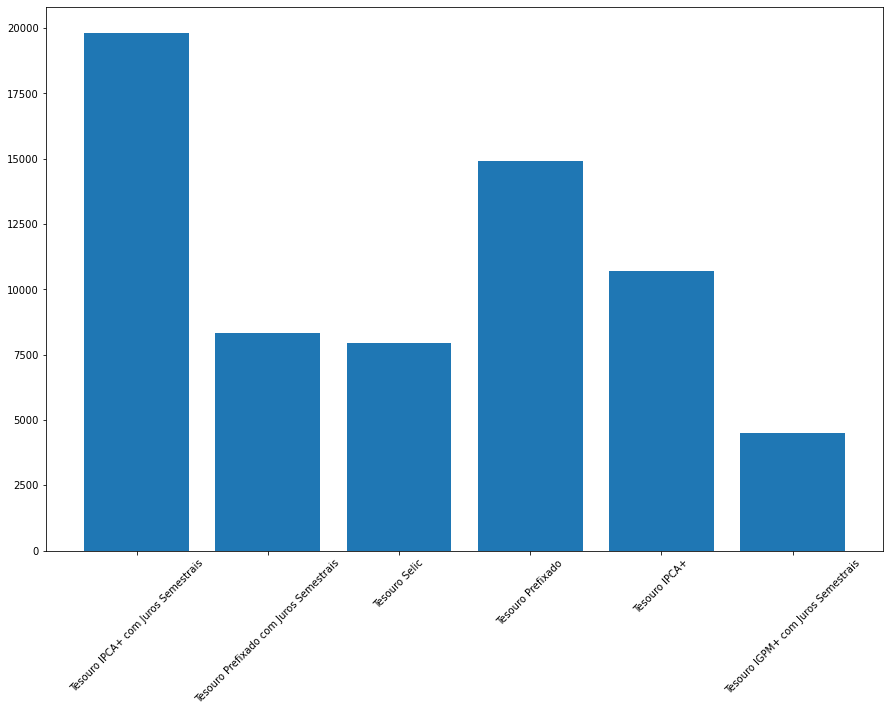

In [9]:
acc = {}
for x in df_data['Tipo_Titulo']:
    if x in acc:
        acc[x] = acc[x] + 1
    else:
        acc[x] = 1
x = acc.keys()
y = acc.values()
fig=plt.figure(figsize=(15,10))
plt.bar(range(len(acc)), list(acc.values()), align='center')
plt.xticks(range(len(acc)), list(acc.keys()))
plt.xticks(rotation=45)
# colocar labels plt.xlabel()
plt.show()

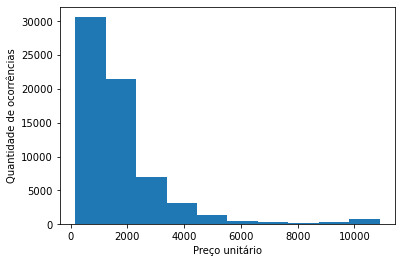

In [10]:
acd = {}
for x in df_data['PU']:
    if x in acd:
        acd[x] = acd[x] + 1
    else:
        acd[x] = 1
        
plt.hist(acd)
plt.xlabel('Preço unitário')
plt.ylabel('Quantidade de ocorrências')
plt.show()

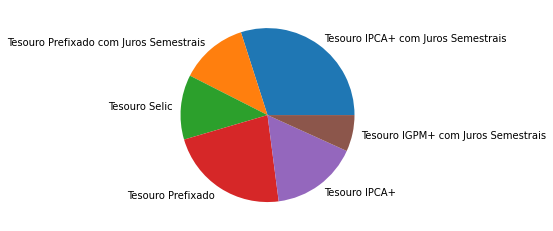

In [11]:
plt.pie([x/len(df_data.value_counts()) for x in acc.values()],labels=acc.keys())
plt.show()

[]

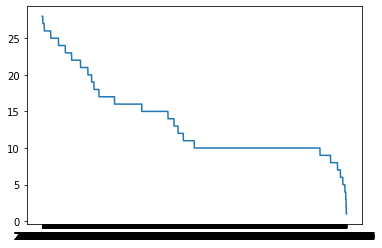

In [12]:

dftwo = df_data['Data_Venda'].value_counts().rename_axis('Data_Venda').reset_index(name='counts')
dftwo['Data_Venda'] = dftwo['Data_Venda'].astype(str)


x=dftwo['Data_Venda']
y=dftwo['counts']
plt.plot(x,y)
plt.plot()

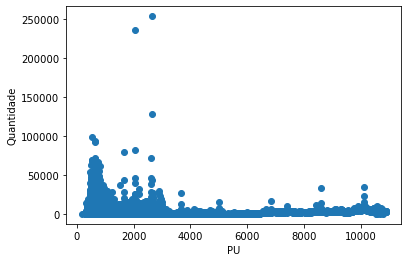

In [13]:
#df_datapu = [x for i, x  in enumerate(df_data['PU']) if i < 1000]
#df_dataqtd = [x for i, x  in enumerate(df_data['Quantidade']) if i < 1000]

#plt.scatter(df_datapu, df_dataqtd)
plt.scatter(df_data['PU'], df_data['Quantidade'])
plt.xlabel('PU')
plt.ylabel('Quantidade')
# pode-se observar que quanto menor o preço unitário, maior é a quantidade vendida
plt.show()

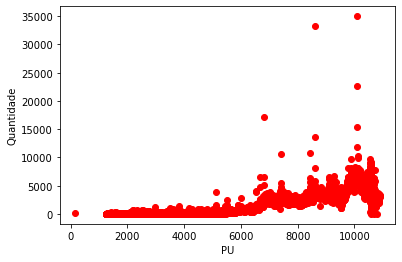

In [14]:
#df_datapu = [x for i, x  in enumerate(df_data['PU']) if i < 1000]
#df_dataqtd = [x for i, x  in enumerate(df_data['Quantidade']) if i < 1000]

#plt.scatter(df_datapu, df_dataqtd)
df_dados_c0=df_data[df_data['Tipo_Titulo']=='Tesouro Prefixado com Juros Semestrais']
df_dados_c1=df_data[df_data['Tipo_Titulo']=='Tesouro Selic']
df_dados_c2=df_data[df_data['Tipo_Titulo']=='Tesouro Prefixado']
df_dados_c3=df_data[df_data['Tipo_Titulo']=='Tesouro Prefixado IPCA+']
df_dados_c4=df_data[df_data['Tipo_Titulo']=='Tesouro IGPM+ com Juros Semestrais']
df_dados_c5=df_data[df_data['Tipo_Titulo']=='Tesouro Prefixado IPCA+ com Juros Semestrais']

#plt.scatter(df_dados_c0['PU'], df_dados_c0['Quantidade'],c='blue')
plt.scatter(df_dados_c1['PU'], df_dados_c1['Quantidade'],c='red')
#plt.scatter(df_dados_c2['PU'], df_dados_c2['Quantidade'],c='green')
#plt.scatter(df_dados_c3['PU'], df_dados_c3['Quantidade'],c='purple')
#plt.scatter(df_dados_c4['PU'], df_dados_c4['Quantidade'],c='yellow')
#plt.scatter(df_dados_c5['PU'], df_dados_c5['Quantidade'],c='red')


plt.xlabel('PU')
plt.ylabel('Quantidade')
# pode-se observar que quanto menor o preço unitário, maior é a quantidade vendida
plt.show()

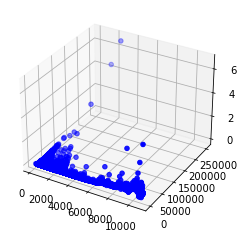

In [15]:

if 'Valor' in df_data.columns:
    ax = plt.axes(projection='3d')
    ax.scatter3D(df_data['PU'].array,df_data['Quantidade'].array,df_data['Valor'].array, color='blue');
    plt.show()

In [16]:
pu = df_data['Quantidade']
# será se deve ser essas colunas mesmo?
df_features = df_data.drop(columns=['Tipo_Titulo', 'Vencimento_do_Titulo', 'Data_Venda', 'Quantidade'])

df_features

,PU,Valor
0,1655.206735,63890.97
1,1480.154343,845168.12
2,870.303177,246469.85
3,936.285273,27339.52
4,808.587250,397663.20
...,...,...
66164,960.339019,105829.35
66165,1672.613421,453612.75
66166,1677.517573,147957.04
66167,946.566666,567.93


In [93]:
#definindo target
Tipo_Titulo=df_data['Tipo_Titulo'].array
#Tirando target e data sem valor numerico
df_features=df_data.drop(columns=['Tipo_Titulo','Data_Venda','Vencimento_do_Titulo'])

#Redimencionando com TSNE
model=TSNE(n_components=2)

array_red=model.fit_transform(df_features)

df_tsne=pd.DataFrame(array_red,columns=['f1','f2'])

#separando data pelo target
df_tsne['Tipo_Titulo']=Tipo_Titulo
#df_tsne_c0=df_tsne[df_tsne['Tipo_Titulo']=='Tesouro Prefixado com Juros Semestrais']
#df_tsne_c1=df_tsne[df_tsne['Tipo_Titulo']=='Tesouro Selic']
#df_tsne_c2=df_tsne[df_tsne['Tipo_Titulo']=='Tesouro Prefixado']
df_tsne_c3=df_tsne[df_tsne['Tipo_Titulo']=='Tesouro Prefixado IPCA+']
#df_tsne_c4=df_tsne[df_tsne['Tipo_Titulo']=='Tesouro IGPM+ com Juros Semestrais']
#df_tsne_c5=df_tsne[df_tsne['Tipo_Titulo']=='Tesouro Prefixado IPCA+ com Juros Semestrais']
#teste
df_tsne_c3

,f1,f2,Tipo_Titulo


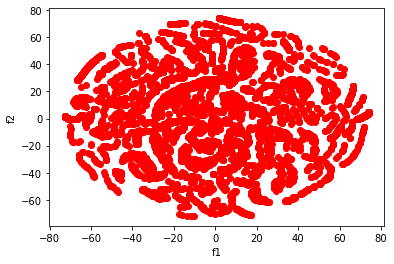

In [18]:
#Fazendo scatte com dado redimencionado

#COMENTEI TUDO MENOS UM PRA VER SE DAVA BOM MAIS CONTINUA SAINDO DATA ILEGIVEL
#plt.scatter(df_tsne_c0['f1'], df_tsne_c0['f2'],c='blue')
plt.scatter(df_tsne_c1['f1'], df_tsne_c1['f2'],c='red')
#plt.scatter(df_tsne_c2['f1'], df_tsne_c2['f2'],c='green')
#plt.scatter(df_tsne_c3['f1'], df_tsne_c3['f2'],c='black')
#plt.scatter(df_tsne_c4['f1'], df_tsne_c4['f2'],c='yellow')
#plt.scatter(df_tsne_c5['f1'], df_tsne_c5['f2'],c='orange')


plt.xlabel('f1')
plt.ylabel('f2')
# pode-se observar que quanto menor o preço unitário, maior é a quantidade vendida
plt.show()



#### Treinando e validando nosso modelo

In [31]:
def getModel():
    #return LinearRegression() # resultados menos efetivos, porém instantaneos e requer pouco processamento
    return RandomForestRegressor() # resultados melhores mas requer muito processamento

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df_features.values, pu, test_size=0.2)
# pq está tão baixo?

model = getModel().fit(X_train, y_train)

score = model.score(X_test,y_test)

score

0.9997648013631754

In [21]:
df_features

,PU,Quantidade,Valor
0,1655.206735,38.6,63890.97
1,1480.154343,571.0,845168.12
2,870.303177,283.2,246469.85
3,936.285273,29.2,27339.52
4,808.587250,491.8,397663.20
...,...,...,...
66164,960.339019,110.2,105829.35
66165,1672.613421,271.2,453612.75
66166,1677.517573,88.2,147957.04
66167,946.566666,0.6,567.93


In [22]:
df_features_c1=df_dados_c1.drop(columns=['Tipo_Titulo','Data_Venda','Vencimento_do_Titulo'])
df_features_c1_datas = df_dados_c1.drop(columns=['Tipo_Titulo','Vencimento_do_Titulo'])
df_features_c1

,PU,Quantidade,Valor
6,3694.700000,83.2,307399.04
9,3692.770059,133.6,493354.07
27,3728.658416,140.2,522757.90
32,3726.728894,39.8,148323.80
47,3730.540024,409.0,1525790.86
...,...,...,...
66128,3534.769820,100.4,354890.88
66138,3566.330371,75.4,268901.30
66144,3567.210000,76.0,271107.96
66162,3568.050000,175.4,625835.97


In [23]:
# somando datas para obter datas futuras
future_dates = df_features_c1_datas['Data_Venda']
first = min(df_features_c1_datas['Data_Venda'])
last = max(df_features_c1_datas['Data_Venda'])
diff = last - first
future_dates = future_dates + np.timedelta64(diff)
future_dates

6       2028-04-16
9       2028-04-16
27      2029-01-06
32      2029-01-06
47      2029-04-05
           ...    
66128   2028-07-04
66138   2028-07-31
66144   2028-07-31
66162   2028-08-01
66168   2028-08-01
Name: Data_Venda, Length: 7957, dtype: datetime64[ns]

In [24]:
# exemplo de filtro por intervalo de datas
def filter_interval (data_frame, min_dt, max_dt):
    min_date = np.datetime64(min_dt)
    max_date = np.datetime64(max_dt)
    filtered = [x for x in data_frame if x < max_date and x > min_date]
    return pd.DataFrame({'filtered': filtered})

def removable_indexes (data_frame, min_dt, max_dt):
    min_date = np.datetime64(min_dt)
    max_date = np.datetime64(max_dt)
    return [i for i, x in enumerate(data_frame) if x >= max_date or x <= min_date]

def remove_indexes (data_frame, indexes):
    return [x for i, x in enumerate(data_frame) if i not in indexes]

r = filter_interval(df_features_c1_datas['Data_Venda'], '2008-05-01', '2008-05-30')
r

,filtered
0,2008-05-12
1,2008-05-12
2,2008-05-11
3,2008-05-11
4,2008-05-23
5,2008-05-23
6,2008-05-09
7,2008-05-09
8,2008-05-06
9,2008-05-06


In [25]:
# número de linhas
len(r['filtered'])

36

In [26]:
x1 = len(df_features_c1_datas['Data_Venda'])
x2 = len(df_features_c1['PU'])
if x1 != x2:
    raise Exception(f'{x1} is not equal to {x2}')

In [27]:
#Tentando fazer o training com df_dados_c1(seriam os dados redimencionados para f1 e f2 dos tesouros de tipo Selic)
pu_selic=df_dados_c1['PU']
data_selic=df_dados_c1['Data_Venda']
X_train, X_test, y_train, y_test = train_test_split(df_features_c1.values, pu_selic, test_size=0.2)
model = getModel().fit(X_train, y_train)

score = model.score(X_test,y_test)

score

0.9999997866041319

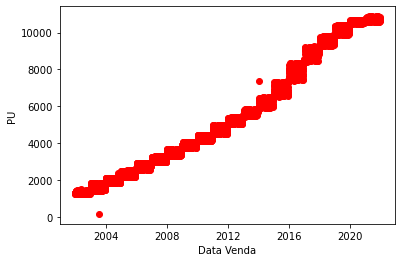

6365

In [28]:
plt.scatter(df_features_c1_datas['Data_Venda'], df_features_c1['PU'],c='red')

plt.ylabel('PU')
plt.xlabel('Data Venda')
plt.show()
len(model.predict(X_train))

In [29]:
plt.scatter(df_features_c1_datas['Data_Venda'],model.predict( df_features_c1['PU']), c='blue')

plt.xlabel('PU')
plt.ylabel('Data Venda')
plt.show()

ValueError: Expected 2D array, got 1D array instead:
array=[3694.7    3692.77   3728.6584 ... 3567.21   3568.05   3568.9302].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

#### Validando de maneira mais elaborada

In [30]:
scores = cross_val_score(getModel(), df_features.values, pu, cv = 10)
# pq está tão baixo?
print('R2=',np.mean(scores))

R2= 0.9849400951487077


#### Fazendo previsões

In [31]:
# cada array deve ter um número por coluna, como temos duas colunas então fica 0.9,0.9 por item por exemplo
model.predict(X_train)

array([ 5534.12685009, 10566.6638135 ,  4495.6756001 , ...,
        4262.09589372, 10501.35635   ,  2108.18439573])

#### VERIFICANDO CORRELAÇÃO

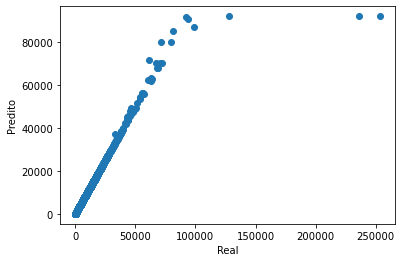

In [32]:
pû = cross_val_predict(getModel(), df_features.values, pu, cv = 20)
plt.scatter(pu, pû)

plt.xlabel('Real')
plt.ylabel('Predito')

plt.show()

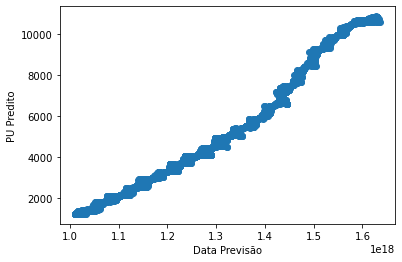

In [34]:
pû_selic = cross_val_predict(getModel(),df_features_c1.values,  pu_selic, cv = 20)
datâ_selic = cross_val_predict(getModel(),df_features_c1.values,  data_selic, cv = 20)
datas = df_dados_c1['Data_Venda']
plt.scatter(datâ_selic, pû_selic)

plt.xlabel('Data Previsão')
plt.ylabel('PU Predito')

plt.show()

In [35]:
pû_selic

array([3688.03585309, 3688.07680454, 3730.78734004, ..., 3565.12598038,
       3565.94379998, 3571.5014221 ])

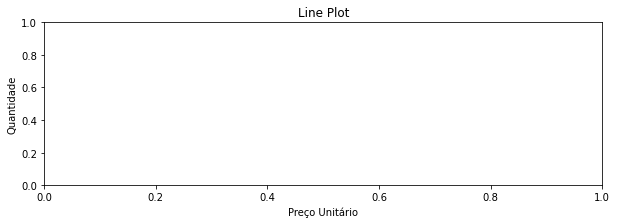

0        False
1        False
2        False
3        False
4        False
         ...  
66164    False
66165    False
66166    False
66167    False
66168     True
Name: Tipo_Titulo, Length: 66169, dtype: bool

In [36]:
fig=plt.figure(figsize=(10,3))
isSelic = df_data['Tipo_Titulo'] == "Tesouro Selic"
#if df_data.isSelic == true:
 #   plt.plot(df_data['PU'][isSelic],df_data['Quantidade'][isSelic])

plt.title('Line Plot')
plt.xlabel('Preço Unitário')
plt.ylabel('Quantidade')
#df_data['PU'][isSelic].value_counts()
plt.show()

isSelic

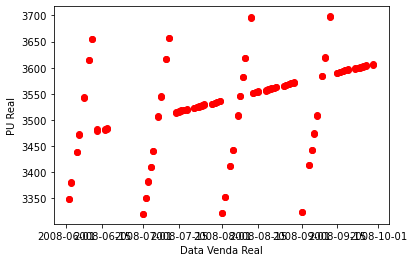

6365

In [37]:
min_date = '2008-06-01'
max_date = '2008-09-30'
filtered_sell_date = filter_interval(df_features_c1_datas['Data_Venda'], min_date, max_date)
pu_invalid_indexes = removable_indexes(df_features_c1_datas['Data_Venda'], min_date, max_date)
filtered_pu = pd.DataFrame({'PU': remove_indexes(df_features_c1['PU'], pu_invalid_indexes)})
#plt.scatter(df_features_c1_datas['Data_Venda'], df_features_c1['PU'],c='red')
plt.scatter(filtered_sell_date, filtered_pu,c='red')

plt.ylabel('PU Real')
plt.xlabel('Data Venda Real')
plt.show()
len(model.predict(X_train))

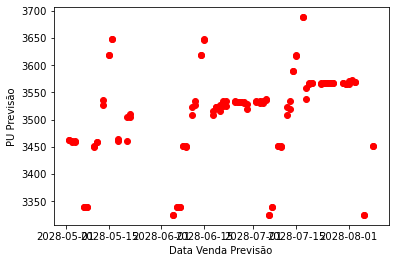

6365

In [38]:
min_date = '2028-05-01'
max_date = '2028-08-10'
filtered_sell_date = filter_interval(future_dates, min_date, max_date)
pu_invalid_indexes = removable_indexes(future_dates, min_date, max_date)
filtered_pu = pd.DataFrame({'PU': remove_indexes(pû_selic, pu_invalid_indexes)})
#plt.scatter(df_features_c1_datas['Data_Venda'], df_features_c1['PU'],c='red')
plt.scatter(filtered_sell_date, filtered_pu,c='red')

plt.ylabel('PU Previsão')
plt.xlabel('Data Venda Previsão')
plt.show()
len(model.predict(X_train))


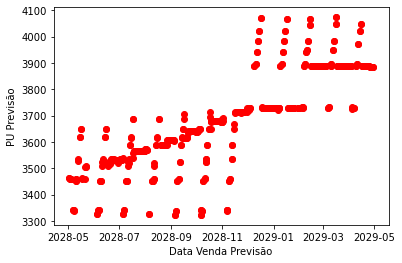

6365

In [42]:
min_date = '2028-05-01'
max_date = '2029-05-01'
filtered_sell_date = filter_interval(future_dates, min_date, max_date)
pu_invalid_indexes = removable_indexes(future_dates, min_date, max_date)
filtered_pu = pd.DataFrame({'PU': remove_indexes(pû_selic, pu_invalid_indexes)})
#plt.scatter(df_features_c1_datas['Data_Venda'], df_features_c1['PU'],c='red')
plt.scatter(filtered_sell_date, filtered_pu,c='red')

plt.ylabel('PU Previsão')
plt.xlabel('Data Venda Previsão')
plt.show()
len(model.predict(X_train))

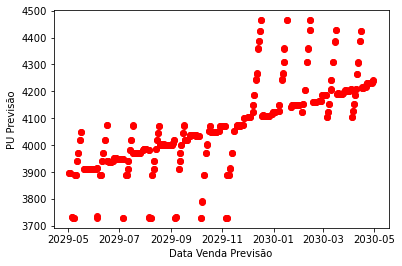

6365

In [43]:
min_date = '2029-05-01'
max_date = '2030-05-01'
filtered_sell_date = filter_interval(future_dates, min_date, max_date)
pu_invalid_indexes = removable_indexes(future_dates, min_date, max_date)
filtered_pu = pd.DataFrame({'PU': remove_indexes(pû_selic, pu_invalid_indexes)})
#plt.scatter(df_features_c1_datas['Data_Venda'], df_features_c1['PU'],c='red')
plt.scatter(filtered_sell_date, filtered_pu,c='red')

plt.ylabel('PU Previsão')
plt.xlabel('Data Venda Previsão')
plt.show()
len(model.predict(X_train))

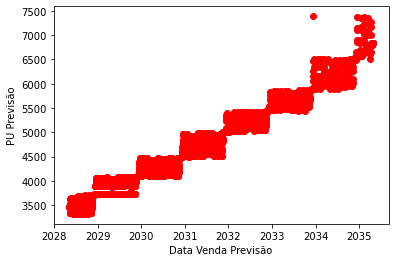

6365

In [45]:
min_date = '2028-05-01'
max_date = '2035-05-01'
filtered_sell_date = filter_interval(future_dates, min_date, max_date)
pu_invalid_indexes = removable_indexes(future_dates, min_date, max_date)
filtered_pu = pd.DataFrame({'PU': remove_indexes(pû_selic, pu_invalid_indexes)})
#plt.scatter(df_features_c1_datas['Data_Venda'], df_features_c1['PU'],c='red')
plt.scatter(filtered_sell_date, filtered_pu,c='red')

plt.ylabel('PU Previsão')
plt.xlabel('Data Venda Previsão')
plt.show()
len(model.predict(X_train))

In [6]:
#Série de vendas totais por mes(Todos)
#Achei melhor seguir com outro aproach no problema
#Decidi que trabalharia com uma tabela com o valor total de todas as vendas de cada mes
#Agora que fiz tudo acho viavel trabalhar sem usar essa tabela, perguntar pro professor o que ele acha melhor?
aux=df_data.drop(columns=['Tipo_Titulo','Vencimento_do_Titulo','PU'])
data_Value_Per_Month=pd.DataFrame(aux.groupby(aux['Data_Venda'].dt.to_period('m'))['Valor'].sum())
data_Value_Per_Month

,Valor
Data_Venda,
2002-01,6.328324e+06
2002-02,8.735493e+06
2002-03,6.765776e+06
2002-04,5.573925e+06
2002-05,5.169537e+06
...,...
2021-08,6.869948e+08
2021-09,5.864650e+08
2021-10,5.798824e+08


<AxesSubplot:title={'center':'Valor Total Mensal'}, xlabel='Data_Venda', ylabel='Valor'>

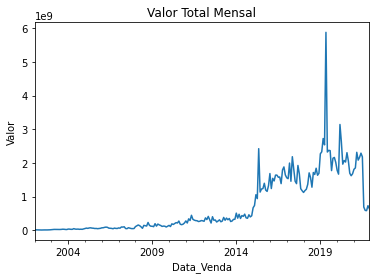

In [7]:
#Aqui temos a serie
plt.xlabel('Meses')
plt.ylabel('Valor')
plt.title('Valor Total Mensal')

data_Value_Per_Month['Valor'].plot()

In [9]:
#Série de vendas totais por mes(Selic)
#Se quiserem podemos fazer com cada tipo
aux=df_data.drop(columns=['Vencimento_do_Titulo','PU','Quantidade'])
aux.set_index('Data_Venda')
data_Value_Per_Month_Selic=pd.DataFrame(aux[aux['Tipo_Titulo']=='Tesouro Selic'].groupby(aux['Data_Venda'].dt.to_period('m'))['Valor'].sum())
data_Value_Per_Month_Selic

,Valor
Data_Venda,
2002-01,4.304474e+05
2002-02,4.275074e+05
2002-03,4.252651e+05
2002-04,3.193325e+05
2002-05,7.717556e+05
...,...
2021-08,2.831883e+08
2021-09,2.305479e+08
2021-10,2.219307e+08


<AxesSubplot:title={'center':'Valor Total Mensal(Selic)'}, xlabel='Data_Venda', ylabel='Valor'>

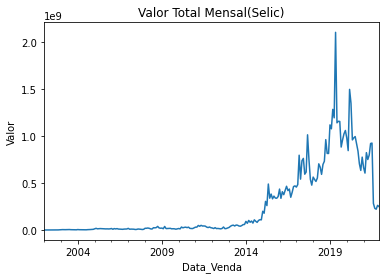

In [10]:
plt.xlabel('Meses')
plt.ylabel('Valor')
plt.title('Valor Total Mensal(Selic)')

data_Value_Per_Month_Selic['Valor'].plot()

In [8]:
##O proximo passo exije que o index da tabela esteja no formato de timestamp
data_Value_Per_Month.index=data_Value_Per_Month.index.to_timestamp()

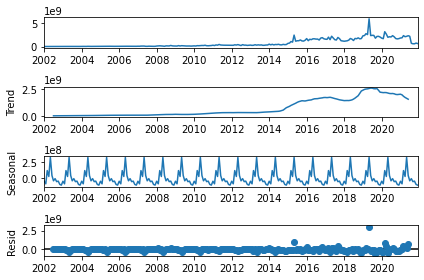

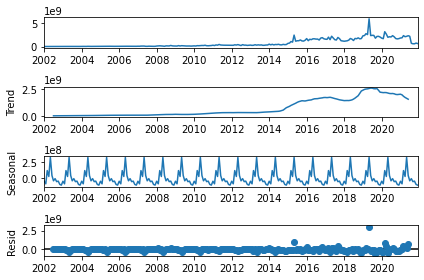

In [22]:
#Seasonal decompese nos da mais detalhes do comportamento da serie ao longo do tempos
result = seasonal_decompose(data_Value_Per_Month)
result.plot()
#Pode se ver que o dado e claramente afetado por estações,a trend esta agora apontando levemente para baixo

In [14]:
#Irei usar o ARIMA (Autoregressive Integrated Moving Average).
#Neste passo estou descobrindo a melhor configuração para o Arima

#Mais detalhes neste site:  
# https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_Value_Per_Month,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue



Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:10635.861719197761
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:10018.759992699856
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:9788.917708400986
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:9260.447288363088
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:9828.338756280438
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:9762.504925319023
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:9300.728799062294
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:9260.113048072697
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:10461.377182672248
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:9911.21288706924
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:9711.71640841254
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:9167.849173645809
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:9966.65261845726
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:9872.925796788459
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - 

In [9]:
#Pegamos a configuração que deu o menor AIC (Akaike Information Critera)
mod = sm.tsa.statespace.SARIMAX(data_Value_Per_Month,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0033      0.118      0.028      0.977      -0.227       0.234
ma.L1         -0.5948      0.100     -5.940      0.000      -0.791      -0.399
ar.S.L12      -0.2454      0.076     -3.218      0.001      -0.395      -0.096
ma.S.L12      -0.7786      0.050    -15.664      0.000      -0.876      -0.681
sigma2       2.27e+17        nan        nan        nan         nan         nan


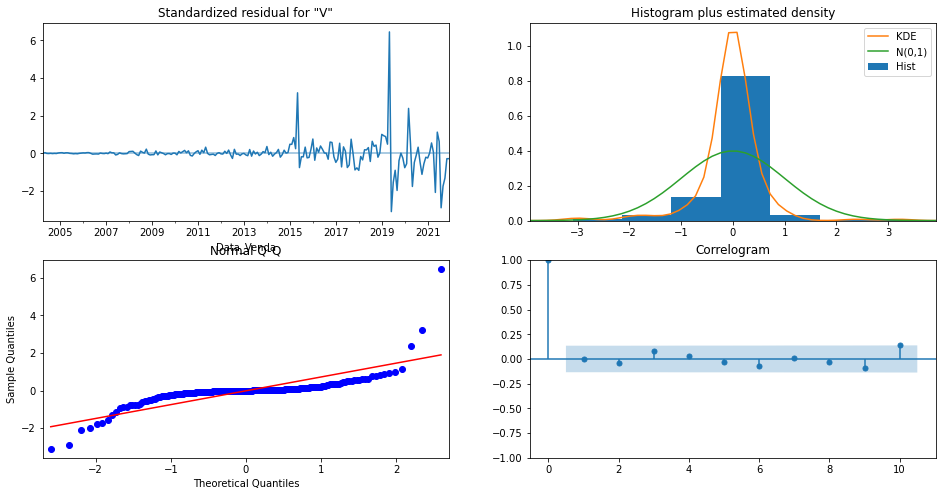

In [10]:
#Diagnosticos são legais XD(I dont know what is happening here but oh boy they sure look cool)
results.plot_diagnostics(figsize=(16, 8))
plt.show()

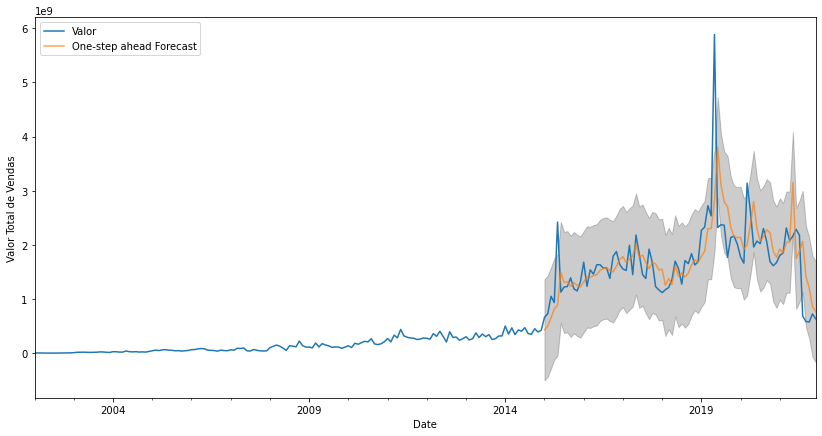

In [11]:
#Nesse grafico podemos ver prediçoes com o ARIMA
#No caso observando o nosso grafico o modelo começa a tentar preve a partir de janeiro de 2015 um mes a frente do real
pred = results.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = data_Value_Per_Month['2002':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Valor Total de Vendas')
plt.legend()
plt.show()

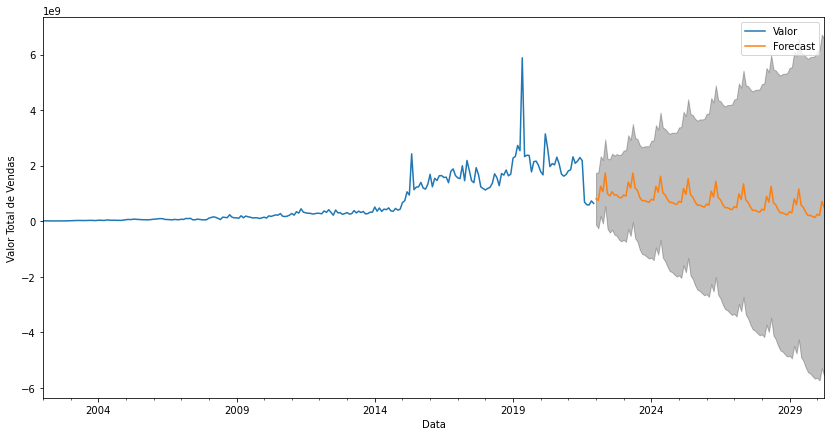

In [12]:
#Aqui temos uma predição de 100 mese no futuro
#A areá cinza conta como uma margem de erro imagino
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = data_Value_Per_Month.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Data')
ax.set_ylabel('Valor Total de Vendas')
plt.legend()
plt.show()
#Talves as vendas baixa antes de 2015 estejam enviezando?